https://www.kaggle.com/c/titanic/data

In [1]:
import pandas as pd
import numpy as np
import re

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rcParams["figure.figsize"] = (8,5)

# Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Models 
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Metrics & model selection
from sklearn.model_selection import cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve

# Scipy
from scipy.stats import reciprocal

# Save model
import joblib
import pickle

In [2]:
train = pd.read_csv("../dataset/train.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train.shape

(891, 12)

The training set has 891 rows and 12 columns.

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Some features seems to have few missing values :

In [5]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# Exploratory Data Analysis

## Survived

0 = No, 1 = Yes

In [6]:
eda_train = train.copy()

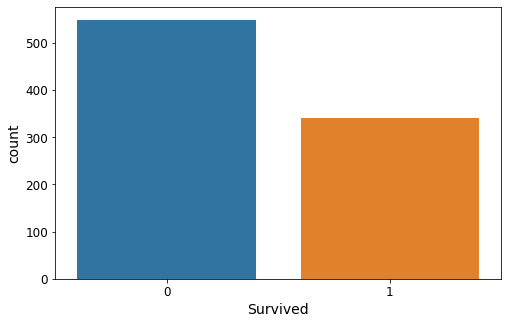

In [7]:
sns.countplot(x="Survived", data=eda_train)
plt.show()

In [8]:
eda_train["Survived"].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

38% of passengers survived, 62% of passengers died.

## Pclass

Ticket class. 1 = 1st, 2 = 2nd, 3 = 3rd

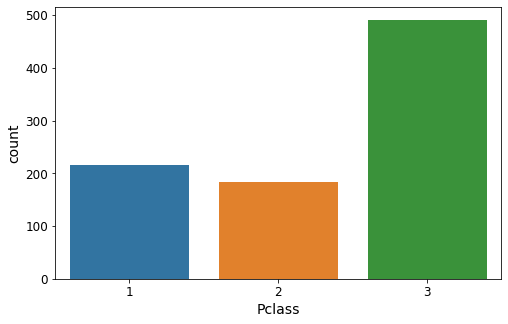

In [9]:
sns.countplot(x="Pclass", data=eda_train)
plt.show()

In [10]:
eda_train.groupby('Pclass')['Survived'].mean().sort_values(ascending=False)

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

## Name

I am going to create a new feature called `Status` to take into account the Mr., Mrs., and so on.

In [11]:
eda_train["Status"] = [re.findall("\,\s(.*?)\.", eda_train["Name"][i])[0] for i in range(len(eda_train))]
eda_train[["Name","Status"]].sample(n=5)

,Name,Status
777,"Emanuel, Miss. Virginia Ethel",Miss
348,"Coutts, Master. William Loch ""William""",Master
197,"Olsen, Mr. Karl Siegwart Andreas",Mr
495,"Yousseff, Mr. Gerious",Mr
815,"Fry, Mr. Richard",Mr


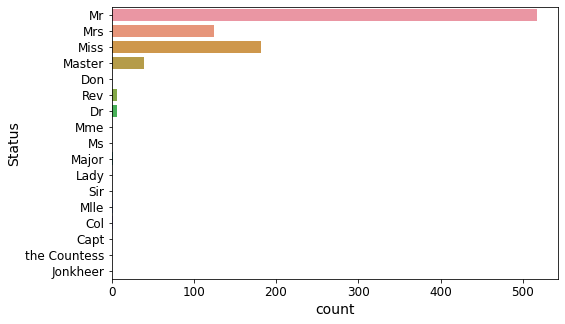

In [12]:
sns.countplot(y="Status", data=eda_train)
plt.show()

In [13]:
five_most_frequent_status = list(eda_train["Status"].value_counts().keys()[:5])
five_most_frequent_status

['Mr', 'Miss', 'Mrs', 'Master', 'Dr']

In [14]:
eda_train["Status_clean"] = [status if status in five_most_frequent_status else "Rare" for status in eda_train["Status"]]

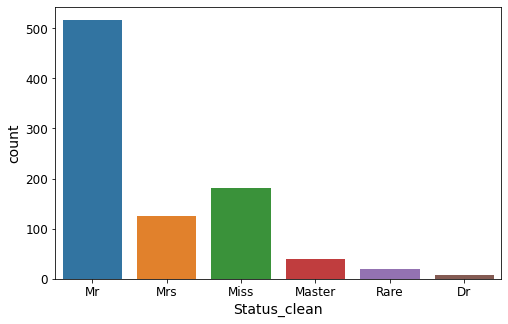

In [15]:
sns.countplot(data=eda_train, x="Status_clean")
plt.show()

In [16]:
eda_train.groupby('Status_clean')['Survived'].mean().sort_values(ascending=False)

Status_clean
Mrs       0.792000
Miss      0.697802
Master    0.575000
Rare      0.450000
Dr        0.428571
Mr        0.156673
Name: Survived, dtype: float64

## Sex

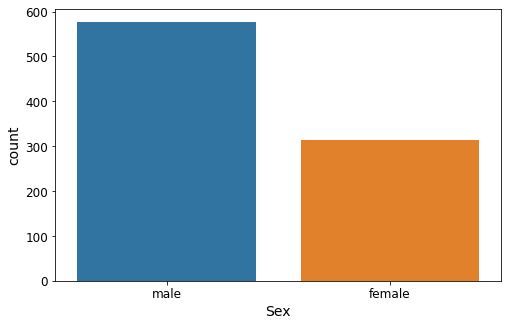

In [17]:
sns.countplot(data=eda_train, x="Sex")
plt.show()

In [18]:
train.groupby('Sex')['Survived'].mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

## SibSp

Number of siblings / spouses aboard the Titanic

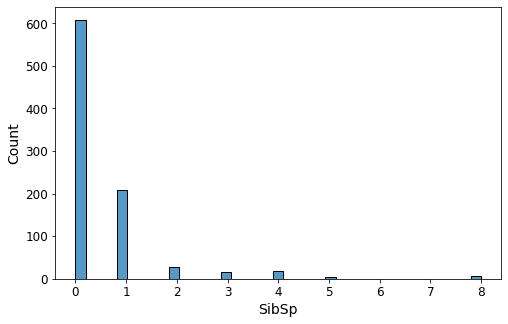

In [19]:
sns.histplot(eda_train['SibSp'], kde=False)
plt.show()

In [20]:
eda_train.groupby('SibSp')['Survived'].mean().sort_values(ascending=False)

SibSp
1    0.535885
2    0.464286
0    0.345395
3    0.250000
4    0.166667
8    0.000000
5    0.000000
Name: Survived, dtype: float64

## Age

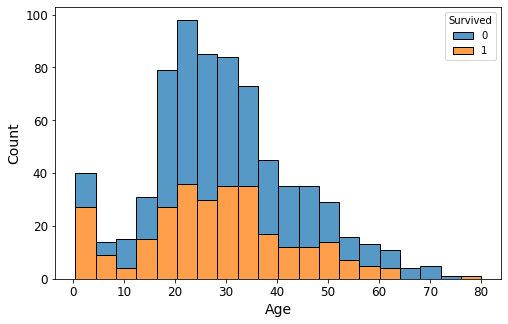

In [21]:
sns.histplot(data=eda_train, x="Age", hue="Survived", multiple="stack")
plt.show()

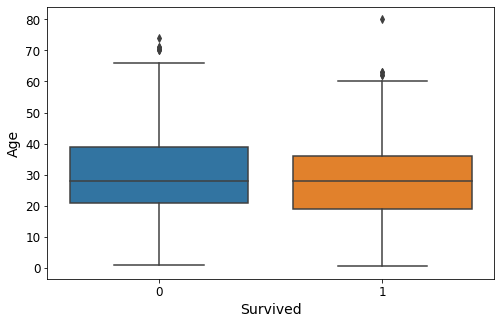

In [22]:
sns.boxplot(x="Survived", y="Age", data=eda_train)
plt.show()

In [23]:
eda_train.groupby('Survived')['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0,424.0,30.626179,14.172110,1.00,21.0,28.0,39.0,74.0
1,290.0,28.343690,14.950952,0.42,19.0,28.0,36.0,80.0


## Parch 

Number of parents / children aboard the Titanic

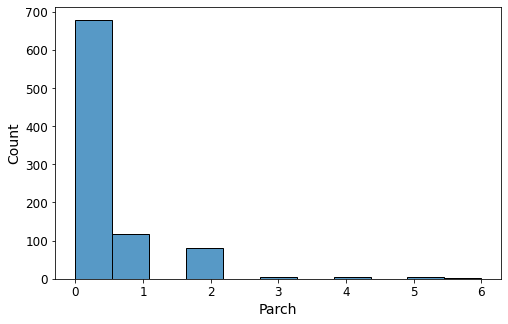

In [24]:
sns.histplot(eda_train['Parch'], kde=False)
plt.show()

In [25]:
eda_train.groupby('Parch')['Survived'].mean().sort_values(ascending=False)

Parch
3    0.600000
1    0.550847
2    0.500000
0    0.343658
5    0.200000
6    0.000000
4    0.000000
Name: Survived, dtype: float64

## Fare 

Passenger fare 

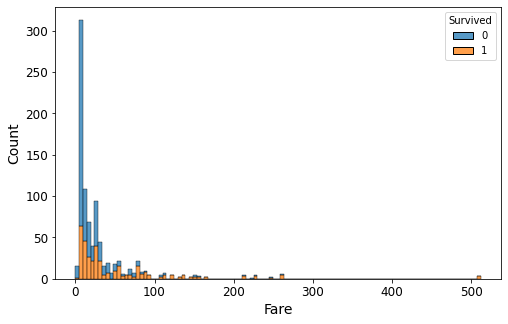

In [26]:
sns.histplot(data=eda_train, x="Fare", hue="Survived", multiple="stack")
plt.show()

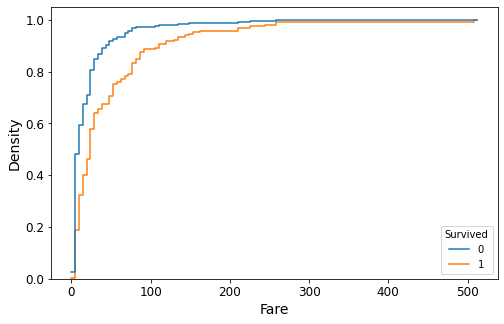

In [27]:
sns.histplot(
    data=eda_train, x="Fare", hue="Survived",
    cumulative=True, fill=False, element="step",
    stat="density", common_norm=False,
)
plt.show()

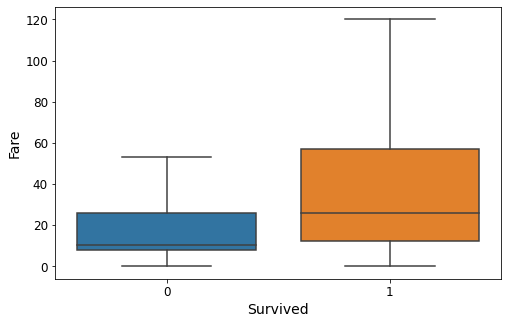

In [28]:
sns.boxplot(x="Survived", y="Fare", data=eda_train, showfliers=False)
plt.show()

In [29]:
eda_train.groupby('Survived')['Fare'].describe()

,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0,549.0,22.117887,31.388207,0.0,7.8542,10.5,26.0,263.0000
1,342.0,48.395408,66.596998,0.0,12.4750,26.0,57.0,512.3292


# Embarked

Port of Embarkation 	C = Cherbourg, Q = Queenstown, S = Southampton

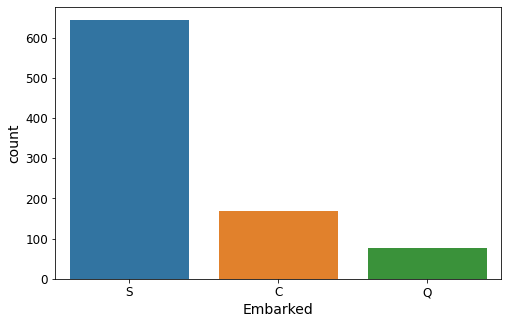

In [30]:
sns.countplot(x="Embarked", data=eda_train)
plt.show()

In [31]:
eda_train.groupby('Embarked')['Survived'].mean().sort_values(ascending=False)

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

## Sex * Embarked

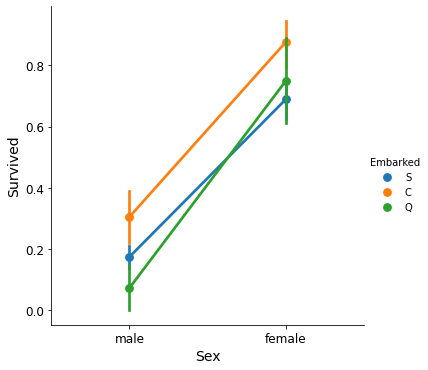

In [32]:
sns.catplot(data=eda_train, x="Sex", y="Survived", hue="Embarked", kind="point")
plt.show()

## Sex * Pclass

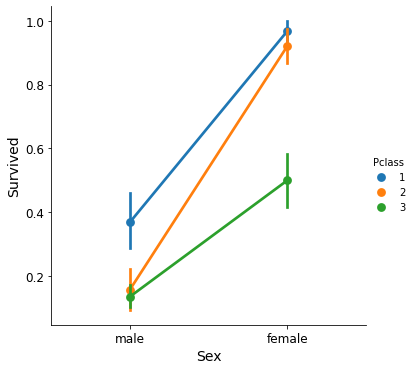

In [33]:
sns.catplot(x="Sex", y="Survived", hue="Pclass", kind="point", data=eda_train)
plt.show()

# Preprocessing

In [34]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [35]:
X_train = train.drop(['Survived', 'PassengerId', 'Ticket', 'Cabin'], axis=1)
y_train = train['Survived']

In [36]:
X_train.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [37]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [38]:
num_attribs = ['Age', 'SibSp', 'Parch', 'Fare']
cat_attribs = ['Pclass', 'Name', 'Sex', 'Embarked']

Let's build a pipeline to prepropressing numerical and categorical attributes :

In [39]:
name_ix = X_train.columns.get_loc("Name") # get the index of the Name column
five_most_frequent_status = ['Mr', 'Miss', 'Mrs', 'Master', 'Dr'] # Reminder

class Status(BaseEstimator, TransformerMixin):
    
    def __init__(self, five_most_frequent_status):
        self.five_most_frequent_status = five_most_frequent_status 
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        status = [re.findall("\,\s(.*?)\.", X[:, name_ix][i])[0] for i in range(len(X))]
        status_clean = [s if s in five_most_frequent_status else "Rare" for s in status]
        output = np.c_[X, status_clean]
        output_without_name = np.delete(output, name_ix, axis=1)
        return output_without_name

In [40]:
num_pipeline = Pipeline([
        ('num_imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
    ('cat_imputer', SimpleImputer(strategy="most_frequent")),
    ('add_status', Status(five_most_frequent_status=five_most_frequent_status)),
    ('ohe', OneHotEncoder()),
])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

X_train_prepared = full_pipeline.fit_transform(X_train)

## Binary classifier

In [41]:
lr = LogisticRegression()
sgd_clf = SGDClassifier(random_state=42)
rf_clf = RandomForestClassifier(random_state=42)
knn_clf = KNeighborsClassifier()
svm_clf = SVC(random_state=42)

list_of_models = [lr, sgd_clf, rf_clf, knn_clf, svm_clf]
list_y_scores = []

for model in list_of_models :
    print('*'*100)
    print(model)
    print('-'*100)
    print("Accuracies with 5-folds cross validation :")
    print(cross_val_score(model, X_train_prepared, y_train, cv=5, scoring="accuracy"))
    print('-'*100)
    y_train_pred = cross_val_predict(model, X_train_prepared, y_train, cv=5)
    
    if model in [lr, rf_clf, knn_clf] :
        y_scores = cross_val_predict(model, X_train_prepared, y_train, cv=5, method="predict_proba")
        list_y_scores.append(y_scores)
    else:
        y_scores = cross_val_predict(model, X_train_prepared, y_train, cv=5, method="decision_function")
        list_y_scores.append(y_scores)
        
    print("Confusion matrix with 5-folds cross validation :")
    print(confusion_matrix(y_train, y_train_pred))
    print('-'*100)
    print("Precision : {:.2f}".format(precision_score(y_train, y_train_pred)))
    print("Recall : {:.2f}".format(recall_score(y_train, y_train_pred)))
    print("F1 : {:.2f}".format(f1_score(y_train, y_train_pred)))
    print('*'*100)

****************************************************************************************************
LogisticRegression()
----------------------------------------------------------------------------------------------------
Accuracies with 5-folds cross validation :
[0.83798883 0.81460674 0.80337079 0.79775281 0.85955056]
----------------------------------------------------------------------------------------------------
Confusion matrix with 5-folds cross validation :
[[478  71]
 [ 87 255]]
----------------------------------------------------------------------------------------------------
Precision : 0.78
Recall : 0.75
F1 : 0.76
****************************************************************************************************
****************************************************************************************************
SGDClassifier(random_state=42)
----------------------------------------------------------------------------------------------------
Accuracies with 5-folds cros

## ROC curves

In [42]:
y_scores_logistic_regression = list_y_scores[0]
y_scores_sgd_clf = list_y_scores[1]
y_scores_rf_clf = list_y_scores[2]
y_scores_knn_clf = list_y_scores[3]
y_scores_svm_clf = list_y_scores[4]

In [43]:
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_train, y_scores_logistic_regression[:, 1])
fpr_sgd, tpr_sgd, thresholds_sgd = roc_curve(y_train, y_scores_sgd_clf)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_train, y_scores_rf_clf[:, 1])
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_train, y_scores_knn_clf[:, 1])
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_train, y_scores_svm_clf)

In [44]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=1.5, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)   
    plt.grid(True) 

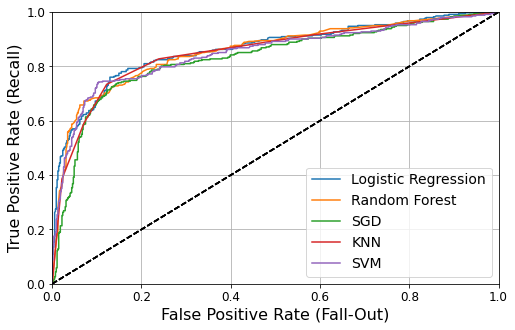

In [45]:
plot_roc_curve(fpr_lr, tpr_lr, "Logistic Regression")
plot_roc_curve(fpr_rf, tpr_rf, "Random Forest")
plot_roc_curve(fpr_sgd, tpr_sgd, "SGD")
plot_roc_curve(fpr_knn, tpr_knn, "KNN")
plot_roc_curve(fpr_svm, tpr_svm, "SVM")
plt.grid(True)
plt.legend(loc="lower right", fontsize=14)
plt.show()

## Fine tune logistic regression

In [46]:
param_distribs = {
        'penalty': ['l1', 'l2'],
        'C': reciprocal(0.01, 10),
        'solver': ['liblinear'],
        'class_weight' : ['balanced', None],
        'fit_intercept' : [True, False],
    }

lr = LogisticRegression()
rnd_search = RandomizedSearchCV(lr, param_distributions=param_distribs,
                                n_iter=500, cv=5, scoring='accuracy',
                                verbose=1, random_state=42)

rnd_search.fit(X_train_prepared, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:    9.9s finished


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=500,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3fffe03e50>,
                                        'class_weight': ['balanced', None],
                                        'fit_intercept': [True, False],
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['liblinear']},
                   random_state=42, scoring='accuracy', verbose=1)

In [47]:
rnd_search.best_score_

0.8282719226664993

In [48]:
rnd_search.best_params_

{'C': 2.0736445177905023,
 'class_weight': None,
 'fit_intercept': False,
 'penalty': 'l2',
 'solver': 'liblinear'}

## Evaluate on test set

In [49]:
final_model = rnd_search.best_estimator_
final_model

LogisticRegression(C=2.0736445177905023, fit_intercept=False,
                   solver='liblinear')

In [50]:
test = pd.read_csv("../dataset/test.csv")
gender_submission = pd.read_csv('../dataset/gender_submission.csv')
test["Survived"] = gender_submission["Survived"]

In [51]:
X_test = test.drop(['Survived', 'PassengerId', 'Ticket', 'Cabin'], axis=1)
y_test = test['Survived']
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

In [52]:
print("* Confusion matrix :")
print(confusion_matrix(y_test, final_predictions))
print("* Accuracy score : {:.2f}".format(accuracy_score(y_test, final_predictions)))
print("* Precision : {:.2f}".format(precision_score(y_test, final_predictions)))
print("* Recall : {:.2f}".format(recall_score(y_test, final_predictions)))
print("* F1 : {:.2f}".format(f1_score(y_test, final_predictions)))

* Confusion matrix :
[[241  25]
 [  9 143]]
* Accuracy score : 0.92
* Precision : 0.85
* Recall : 0.94
* F1 : 0.89
